# Combined meta-study heart DE: covid versus healthy

Stephen Fleming

20210204

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

from harmony import harmonize

from sc_utils import limma_voom_DE, gsea_from_DE, calculate_bkg_prob, \
    all_volcano_plots, volcano_plot, plot_pathway_heatmap, plot_pathway_bars, cell_count_dotplot

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.__version__

'1.6.1'

In [3]:
import harmony
harmony.__version__

'0.1.3'

In [4]:
sc.set_figure_params(vector_friendly=True)

## Re-do UMAPs

In [3]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'individual_colors', 'method_colors', 'neighbors', 'pca', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

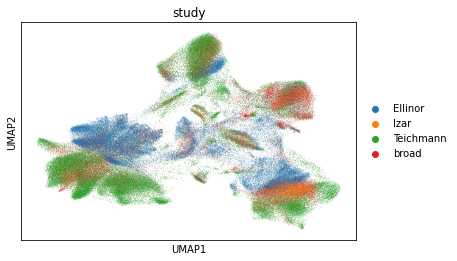

In [5]:
sc.pl.umap(adata, color='study')

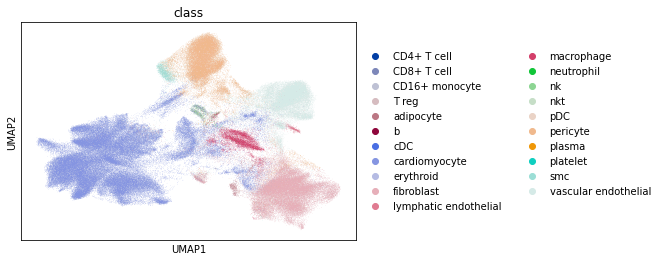

In [6]:
sc.pl.umap(adata, color='class')

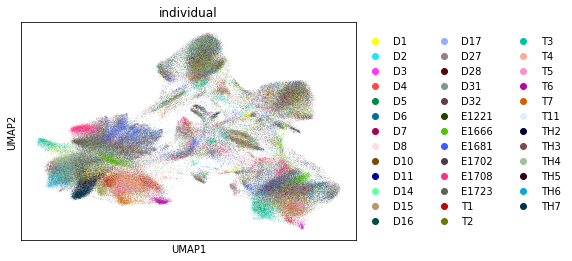

In [7]:
sc.pl.umap(adata, color='individual')

In [8]:
def simplify_clusters(k):
    """Simplify the cluster naming mainly by grouping immune cells"""
    
    if k == 'smc':
        return 'vsmc'
    elif k in ['nk', 'CD8+ T cell', 'T reg', 'CD16+ monocyte', 'erythroid', 'plasma', 
               'b', 'nkt', 'neutrophil', 'platelet', 'CD4+ T cell', 'cDC', 'pDC']:
        return 'immune'
    else:
        return k

adata.obs['cluster'] = adata.obs['class'].apply(simplify_clusters)

In [9]:
adata.obs['cluster'].value_counts()

cardiomyocyte            104182
fibroblast                39142
pericyte                  31001
vascular endothelial      22438
macrophage                 6986
vsmc                       2455
immune                     1884
adipocyte                  1452
lymphatic endothelial       692
Name: cluster, dtype: int64

In [10]:
adata.var.head()

highly_variable     means  dispersions  dispersions_norm  \
featurekey                                                             
A1BG                  False  0.042061     2.443475          0.467080   
A1BG-AS1               True  0.059343     2.520888          0.615214   
A1CF                  False  0.016065     2.127519         -0.125796   
A2M                   False  1.176549     2.891701          0.580369   
A2M-AS1               False  0.036844     2.393191          0.316106   

            highly_variable_nbatches  highly_variable_intersection  
featurekey                                                          
A1BG                               2                         False  
A1BG-AS1                           3                         False  
A1CF                               1                         False  
A2M                                2                         False  
A2M-AS1                            1                         False

In [11]:
adata.var['highly_variable'].sum()

2676

In [15]:
# normalize and log scale
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# do PCA
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

# batch-correct with Harmony

adata.obsm['X_harmony'] = harmonize(adata.obsm['X_pca'], adata.obs, batch_key=['study', 'individual'])

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/home/jupyter-user/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [17]:
# neighbors
sc.pp.neighbors(adata, use_rep='X_harmony', n_neighbors=15, metric='cosine')

# umap
sc.tl.umap(adata, min_dist=0.2, spread=0.2)

/home/jupyter-user/.local/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


... storing 'cluster' as categorical


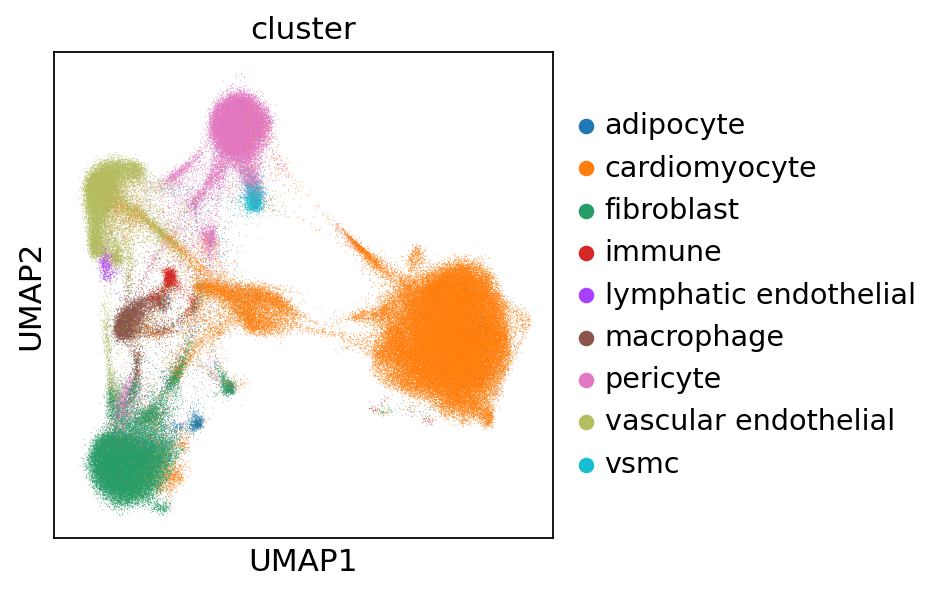

In [18]:
sc.pl.embedding(adata, basis='umap', color='cluster')

In [ ]:
plt.figure(figsize=(7, 5))
sc.pl.embedding(adata, 
                basis='umap', color='cluster', color_map='Oranges', size=1, alpha=0.5,
                vmax=10, ax=plt.gca(), show=False)
plt.title(f'Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_cluster_umap.pdf')

plt.show()

plt.figure(figsize=(6, 5))
sc.pl.embedding(adata, 
                basis='umap', color='study', color_map='Oranges', size=3, alpha=0.1,
                vmax=10, ax=plt.gca(), show=False)
plt.title(f'Study')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_study_umap.pdf')

plt.show()

plt.figure(figsize=(7, 5))
sc.pl.embedding(adata, 
                basis='umap', color='individual', color_map='Oranges', size=1, alpha=0.5,
                vmax=10, ax=plt.gca(), show=False)
plt.title(f'Individual')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_individual_umap.pdf')

plt.show()

In [ ]:
# umaps

sc.set_figure_params(vector_friendly=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sc.pl.embedding(adata[adata.obs['disease'] == 'COVID19'], 
                basis='umap', ax=plt.gca(), show=False)
plt.subplot(1, 2, 2)
sc.pl.embedding(adata[adata.obs['disease'] == 'healthy'], 
                basis='umap', ax=plt.gca(), show=False)
plt.show()

for g in ['PLCG2', 'HIVEP2', 'AFDN']:
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sc.pl.embedding(adata[adata.obs['disease'] == 'COVID19'], 
                    basis='umap', color=g, color_map='Oranges', size=10, alpha=0.5,
                    vmax=10, ax=plt.gca(), show=False)
    plt.title(f'{g}: COVID19 data')
    plt.subplot(1, 2, 2)
    sc.pl.embedding(adata[adata.obs['disease'] == 'healthy'], 
                    basis='umap', color=g, color_map='Oranges', size=10, alpha=0.5,
                    vmax=10, ax=plt.gca(), show=False)
    plt.title(f'{g}: healthy data')
    
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_{g}_umaps.pdf')
    
    plt.show()

## Looking at QCs

In [36]:
adata.obs['scrublet'] = pd.read_csv(
    '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_scrublet.csv', 
    index_col=0, header=None)[1]

adata.obs['entropy'] = pd.read_csv(
    '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_entropy.csv', 
    index_col=0, header=None)[1]

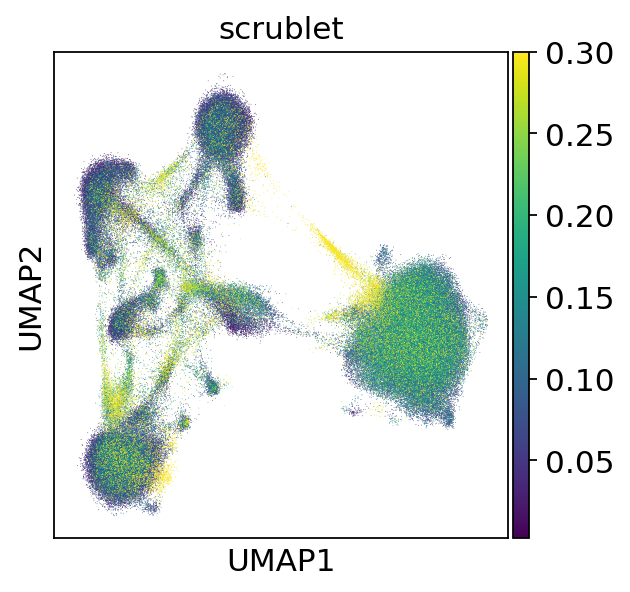

In [37]:
sc.pl.embedding(adata, basis='umap', color='scrublet', vmax=0.3)

In [67]:
adata.obs['n_gene'] = np.array((adata.layers['counts'] > 0).sum(axis=1)).squeeze()
adata.obs['n_umi'] = np.array(adata.layers['counts'].sum(axis=1)).squeeze()

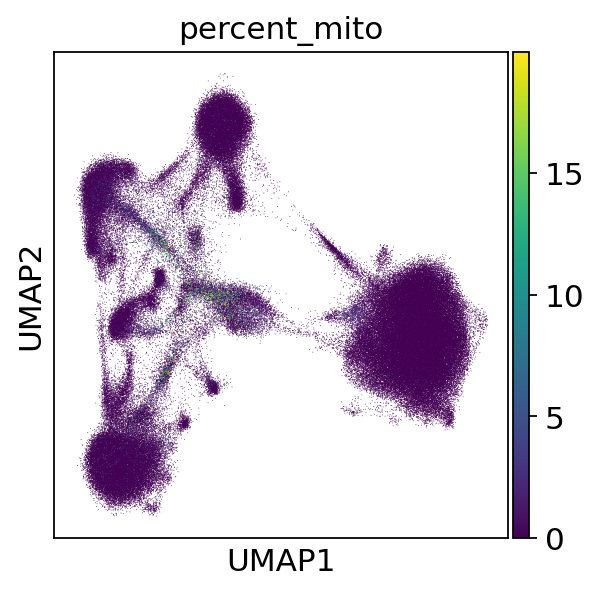

In [95]:
sc.pl.embedding(adata, basis='umap', color='percent_mito')#, vmax=10000)

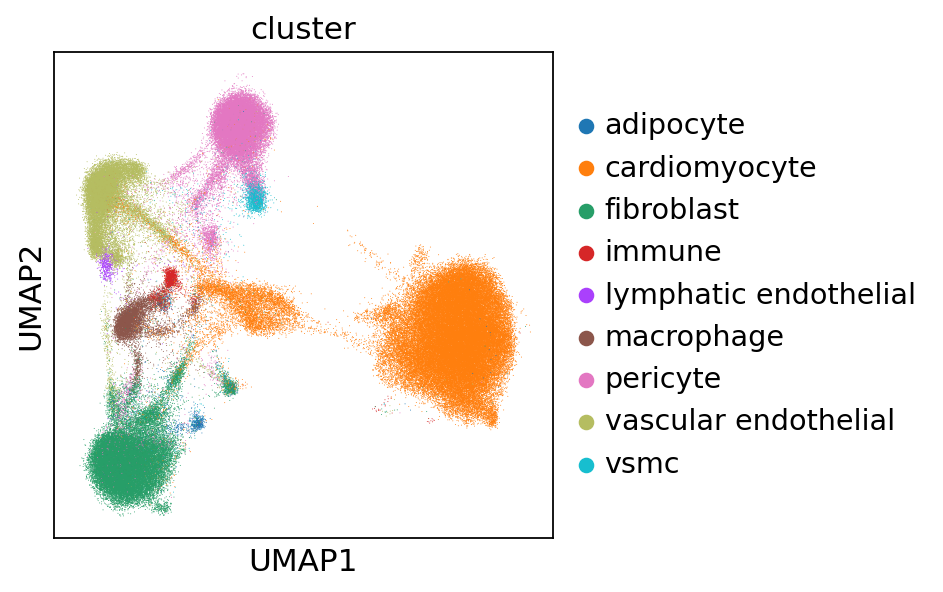

In [49]:
sc.pl.embedding(adata[(adata.obs['scrublet'] < 0.25)
                      & (adata.obs['percent_mito'] < 5)
                      & (adata.obs['entropy'] > 6)
                      & (adata.obs['entropy'] < 8)
                      & (adata.obs['n_gene'] > 200)
                      & (adata.obs['n_gene'] < 3000)], basis='umap', color='cluster', vmax=0.3)

In [73]:
sc.tl.leiden(adata, resolution=1)

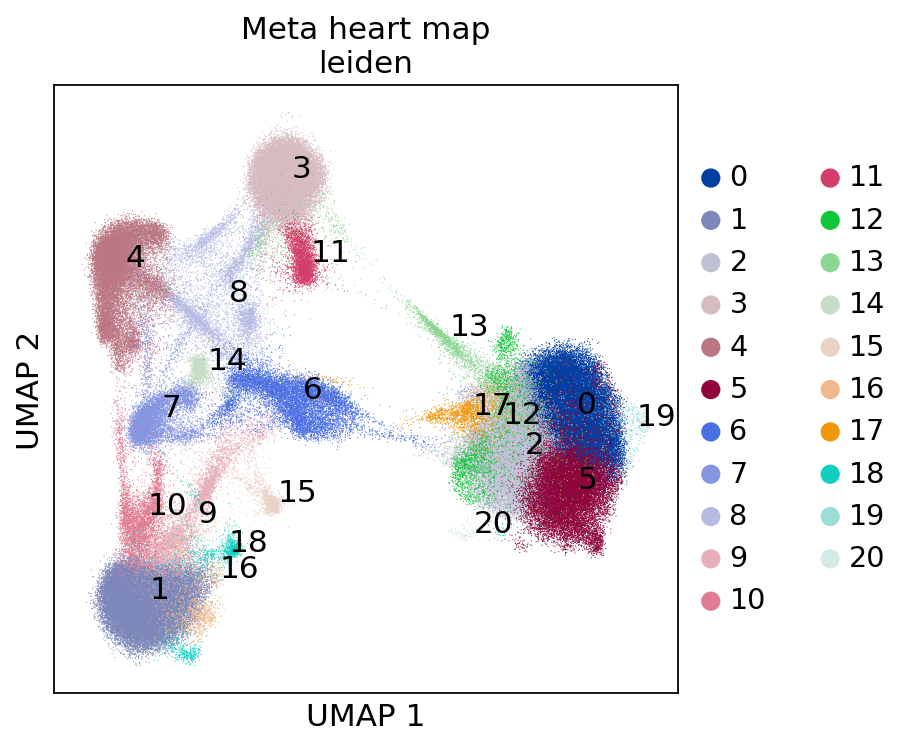

In [97]:
# umap

# show clustering with numbers

key = 'leiden'

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Meta heart map\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [75]:
!rm /home/jupyter-user/analysis/meta/heart_combined_for_de.h5ad

In [77]:
adata.write('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC.h5ad')

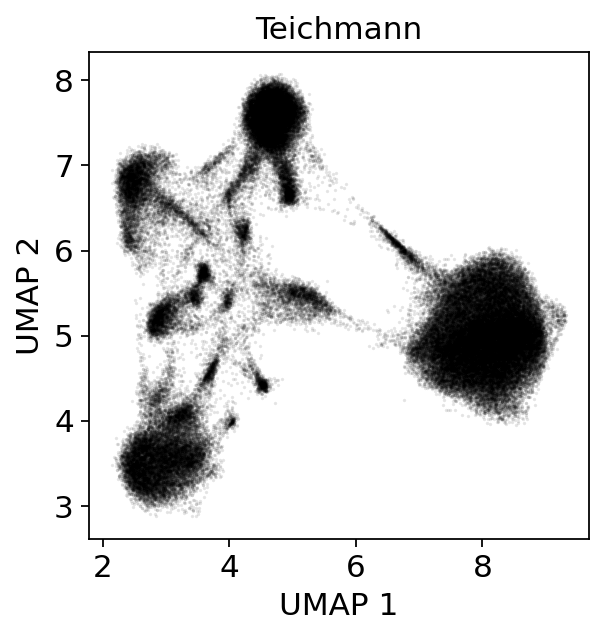

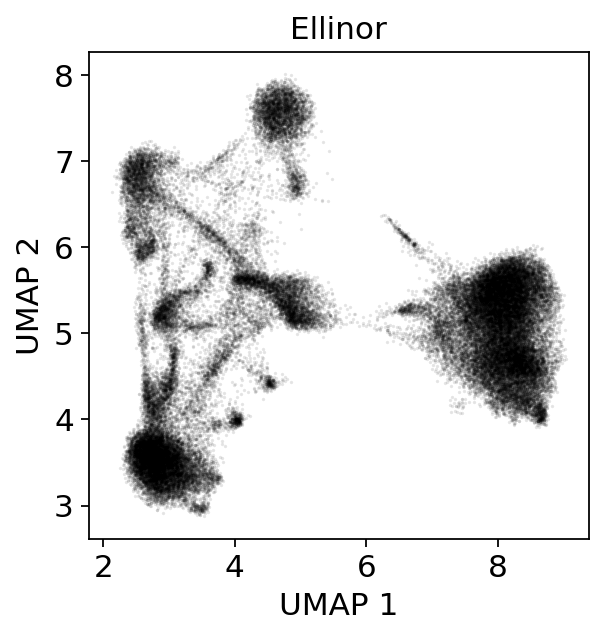

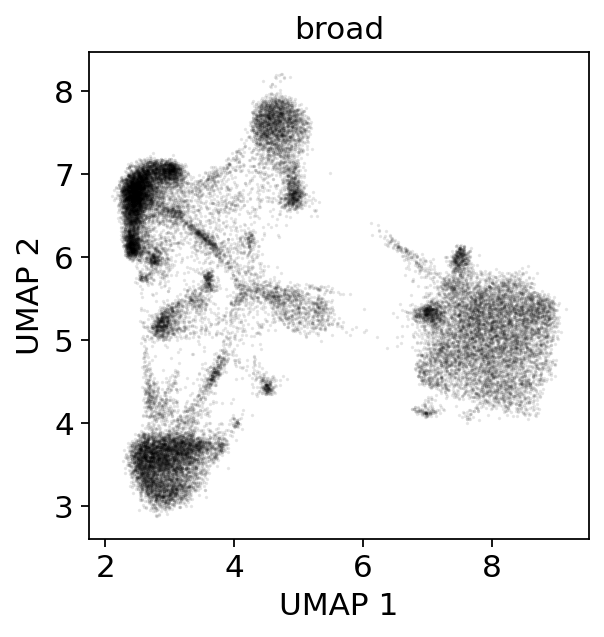

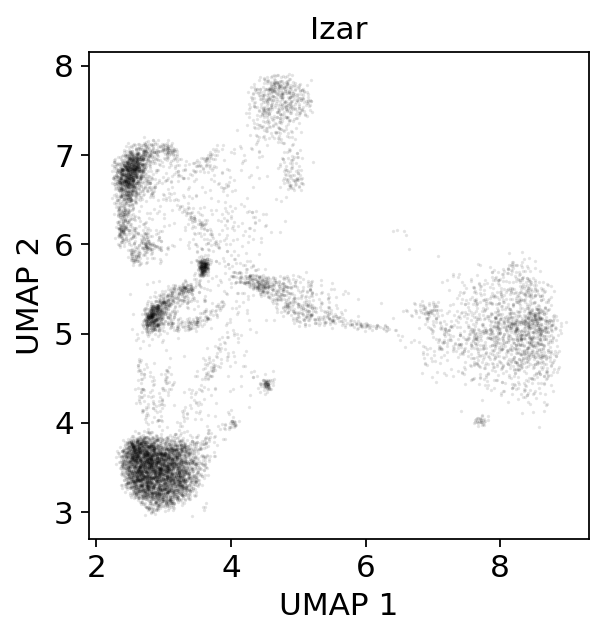

In [116]:
for s in adata.obs['study'].unique():
    
    plt.figure(figsize=(4, 4))
    plt.plot(adata[adata.obs['study'] == s].obsm['X_umap'][:, 0], 
             adata[adata.obs['study'] == s].obsm['X_umap'][:, 1], 
             '.k', ms=1, alpha=0.1, rasterized=True)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.grid(False)
    plt.title(s)
    plt.show()

In [81]:
# cursory marker genes via wilcoxon test

key = 'leiden'

sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)

/home/jupyter-user/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


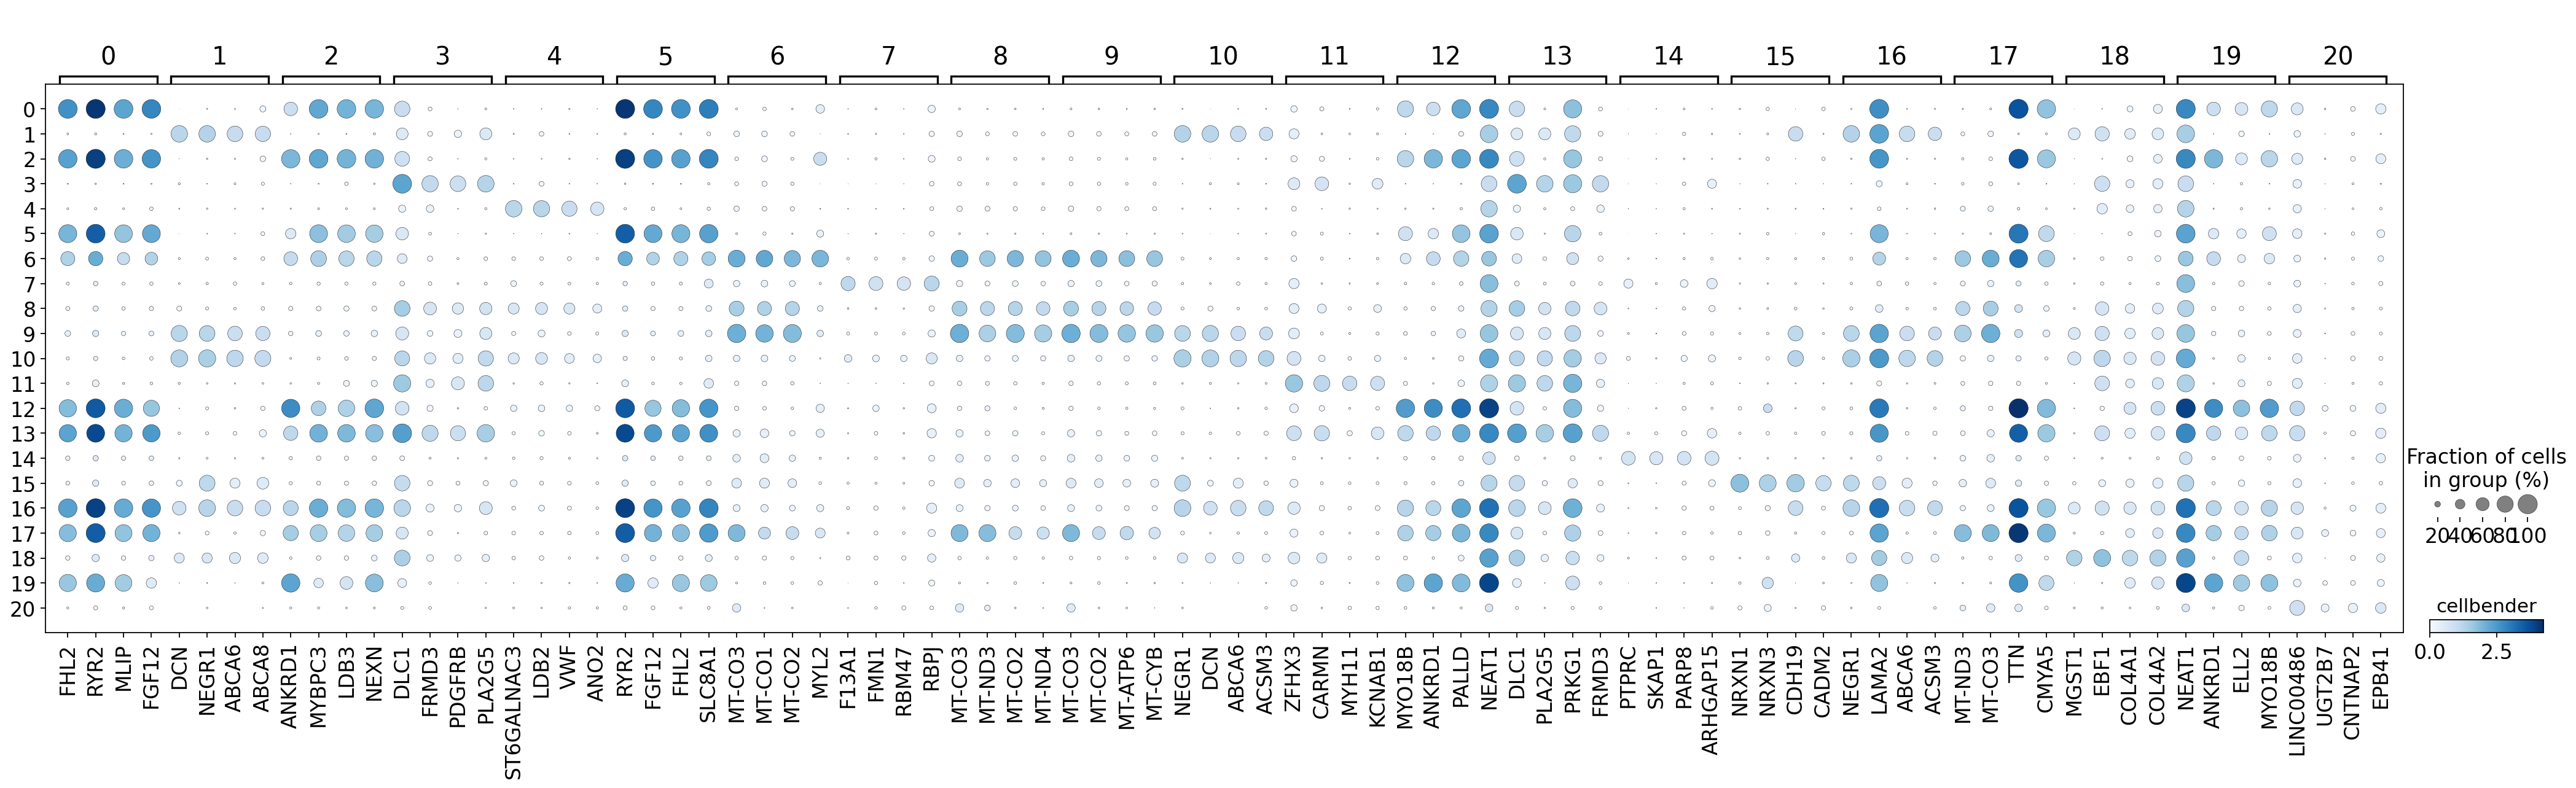

In [100]:
# plot marker genes for the outlier "clusters"
n = 4

cluster_key = 'leiden'

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    g_list = []
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan' and g != 'MALAT1':
            g_list.append(g)
            i += 1
    unique_markers.update({str(k): g_list})

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='counts',
              groupby=cluster_key,
              log=True,
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellbender')
plt.show()

In [93]:
adata.obs['mito_frac'] = np.array(adata.layers['counts']
                                  [:, adata.var_names.str.startswith('MT-')].sum(axis=1)).squeeze()

adata.obs['mito_frac'] = adata.obs['mito_frac'] / adata.obs['n_umi']

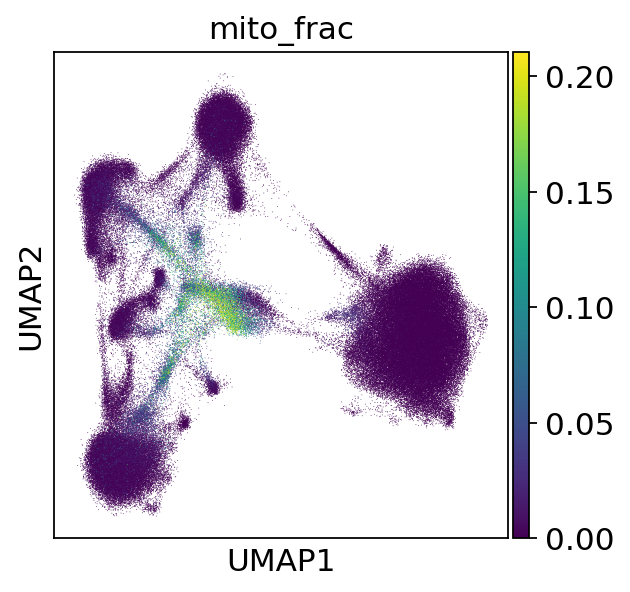

In [94]:
sc.pl.embedding(adata, basis='umap', color='mito_frac')

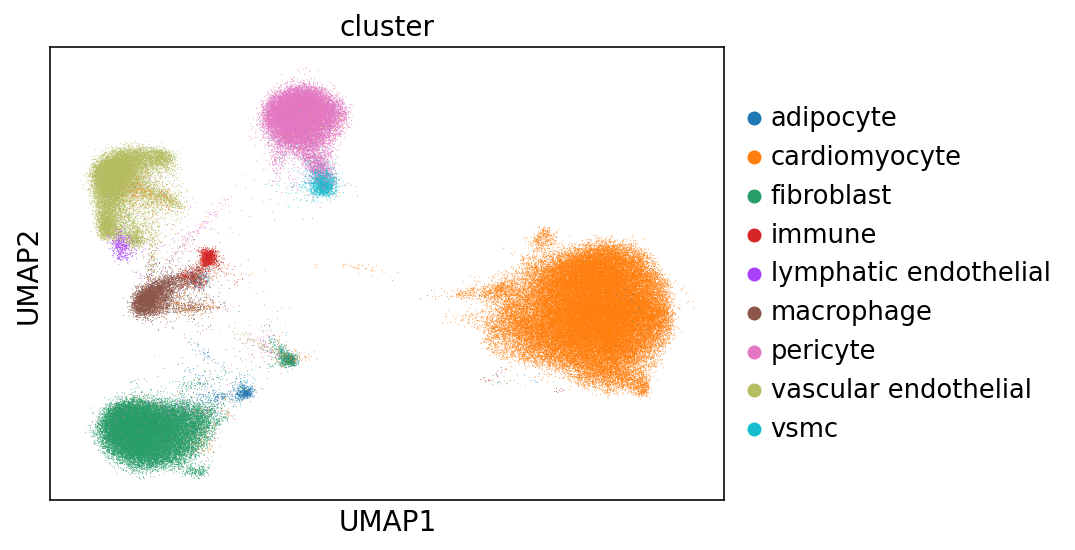

In [138]:
mito_clusters = ['6', '8', '9']
doublet_clusters = ['10', '13']#, '16']

sc.pl.embedding(adata[(adata.obs['scrublet'] < 0.3)
                      & (adata.obs['mito_frac'] < 0.05)
                      & (adata.obs['entropy'] > 6)
                      & (adata.obs['entropy'] < 8)
                      & (~adata.obs['leiden'].isin(mito_clusters + doublet_clusters))], 
                basis='umap', color='cluster', vmax=0.3)

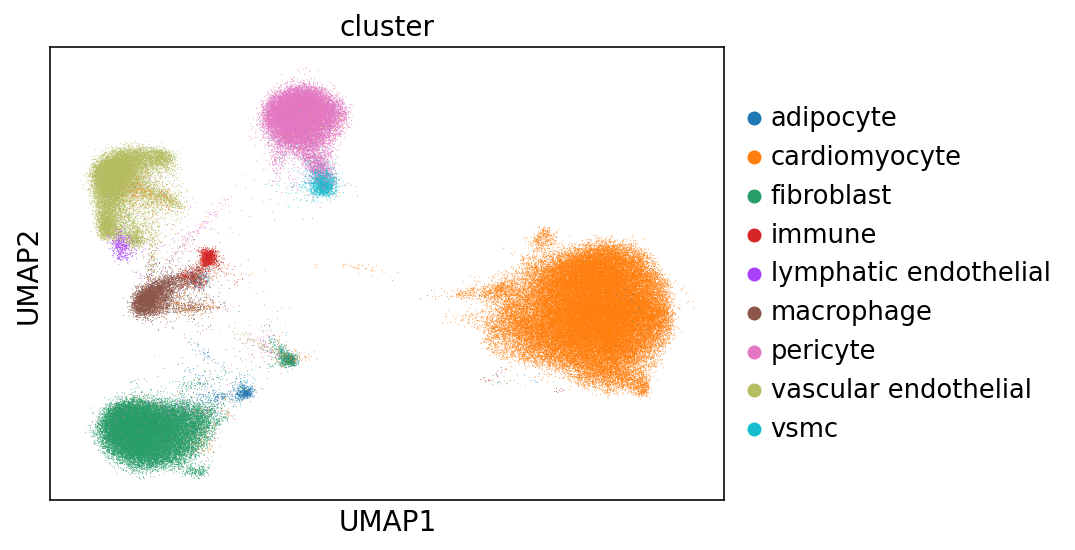

In [141]:
mito_clusters = ['6', '8', '9']
doublet_clusters = ['10', '13']

sc.pl.embedding(adata[(adata.obs['scrublet'] < 0.3)
                      & (adata.obs['mito_frac'] < 0.05)
                      & (adata.obs['entropy'] > 6)
                      & (adata.obs['entropy'] < 8)
                      & (~adata.obs['leiden'].isin(mito_clusters + doublet_clusters))], 
                basis='umap', color='cluster', vmax=0.3)

In [142]:
pd.Series(adata[(adata.obs['scrublet'] < 0.3)
                      & (adata.obs['mito_frac'] < 0.05)
                      & (adata.obs['entropy'] > 6)
                      & (adata.obs['entropy'] < 8)
                      & (~adata.obs['leiden'].isin(mito_clusters + doublet_clusters))].obs.index).to_csv(
    '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC_barcodes.csv', 
    index=False, header=0)

In [143]:
!head /home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC_barcodes.csv

H0015_LV-GTTACGAAGGACAACC
H0015_LV-GGTGAAGGTGAATTGA
H0015_LV-TTACGTTTCCTCACCA
H0015_LV-ACTTTCATCTCTTCAA
H0015_LV-GATCACAGTCTACAAC
H0015_LV-GCTACCTAGTCACACT
H0015_LV-AAACCCAGTTGTAAAG
H0015_LV-TCATGGACAATCCAGT
H0015_LV-GACCTTCAGCGCTGAA
H0015_LV-GAGGCCTGTATGCTAC


In [144]:
!wc -l /home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC_barcodes.csv

151373 /home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC_barcodes.csv


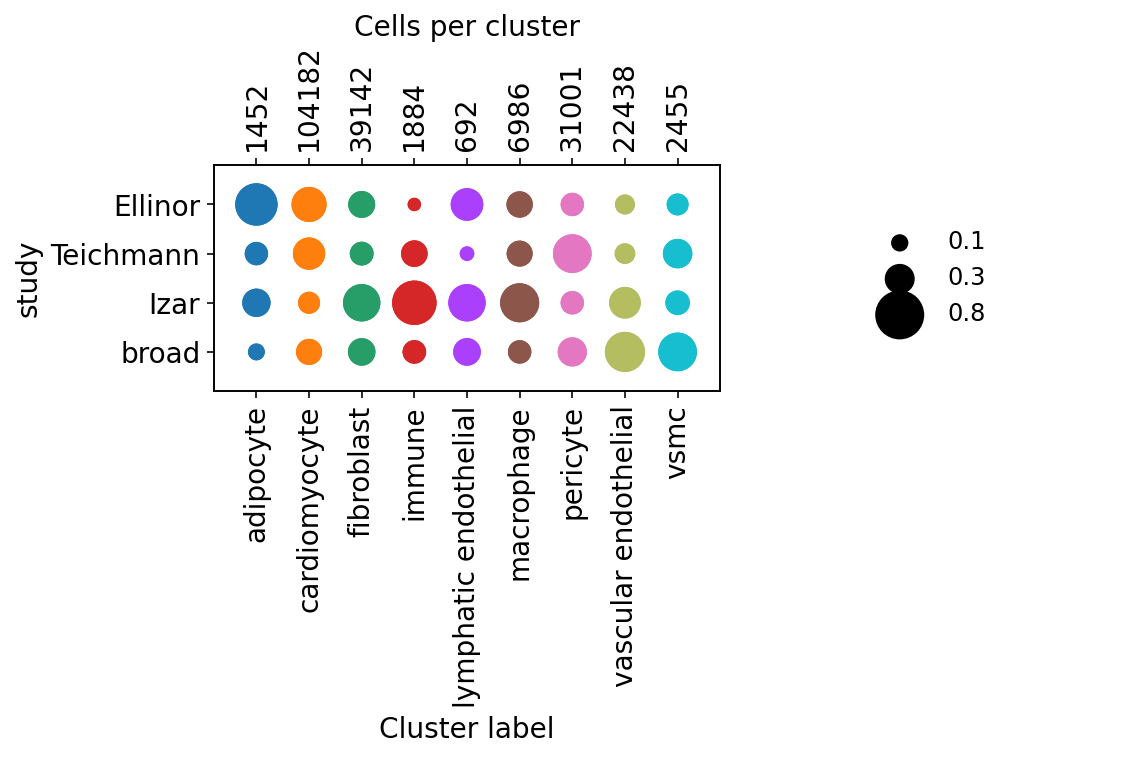

In [136]:
cell_count_dotplot(adata, cluster_key='cluster', key='study', 
                   normalize='row_then_column', xrotation=90,
                   specified_key_order=['broad', 'Izar', 'Teichmann', 'Ellinor'],
                   size_factor=1.5, dot_size_legend_sizes=[0.1, 0.3, 0.8])

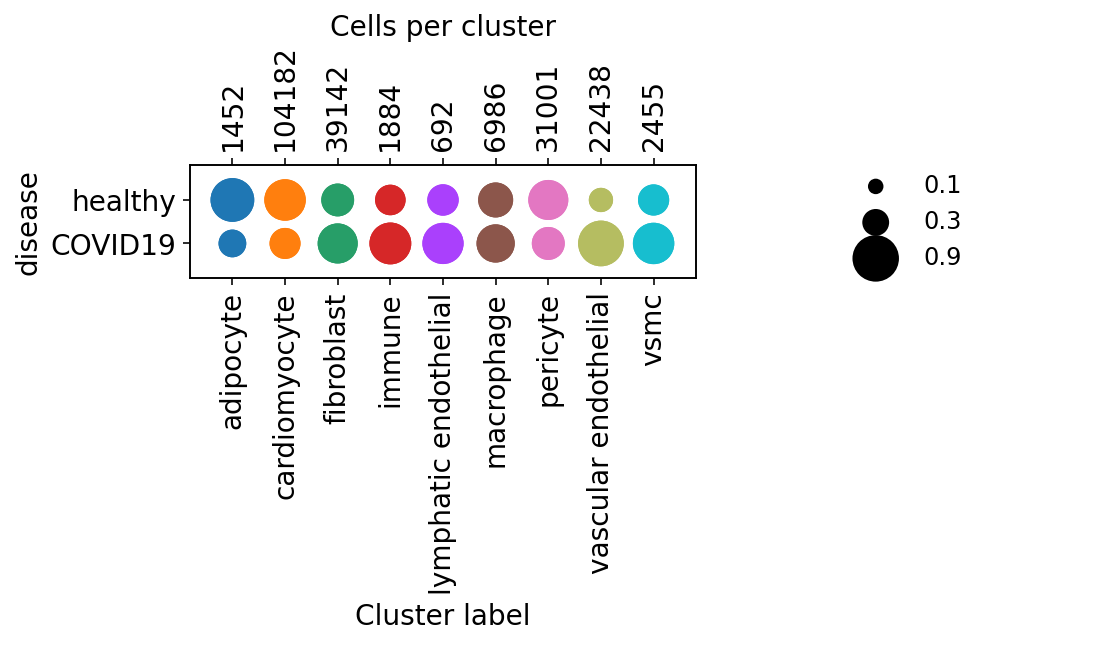

In [135]:
cell_count_dotplot(adata, cluster_key='cluster', key='disease', 
                   normalize='row_then_column', xrotation=90,
                   size_factor=1.2, dot_size_legend_sizes=[0.1, 0.3, 0.9])

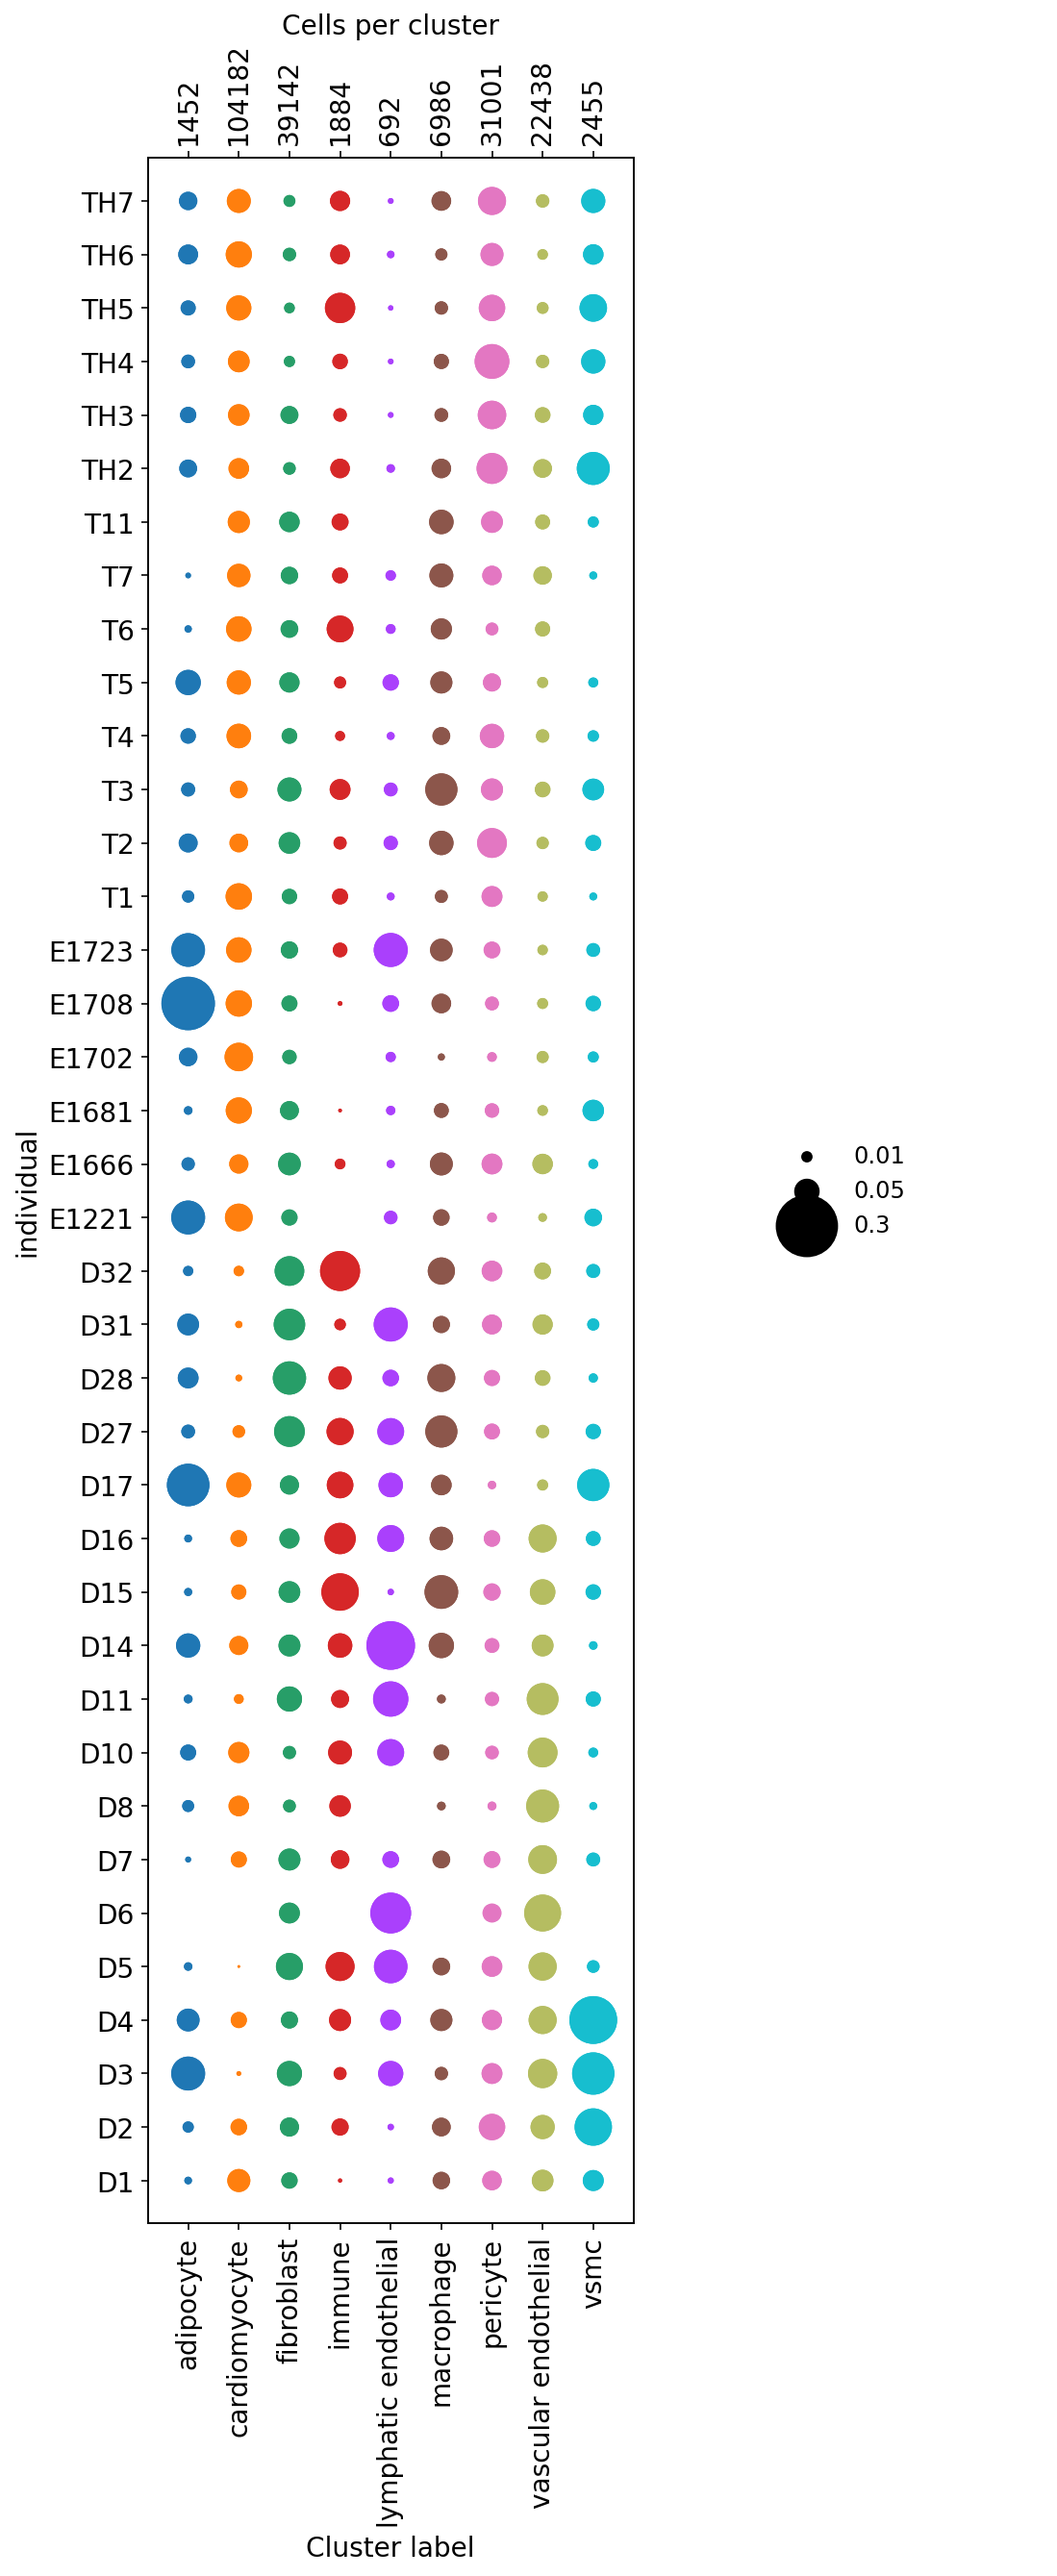

In [127]:
cell_count_dotplot(adata, cluster_key='cluster', key='individual', 
                   normalize='row_then_column', xrotation=90, 
                   size_factor=7, dot_size_legend_sizes=[0.01, 0.05, 0.3])

In [146]:
adata = adata[(adata.obs['scrublet'] < 0.3)
              & (adata.obs['mito_frac'] < 0.05)
              & (adata.obs['entropy'] > 6)
              & (adata.obs['entropy'] < 8)
              & (~adata.obs['leiden'].isin(mito_clusters + doublet_clusters))]

In [147]:
adata

View of AnnData object with n_obs × n_vars = 151373 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster', 'scrublet', 'entropy', 'n_gene', 'loggene_entropy', 'p_diff', 'n_umi', 'leiden', 'mito_frac'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'individual_colors', 'neighbors', 'pca', 'study_colors', 'umap', 'log1p', 'cluster_colors', 'leiden', 'leiden_colors', 'rank_genes_groups_leiden'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Re-do UMAP: just good cells

In [151]:
import gc
gc.collect()

47

In [152]:
# # normalize and log scale
# adata.X = adata.layers['counts'].copy()
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)

# do PCA
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

# batch-correct with Harmony

adata.obsm['X_harmony'] = harmonize(adata.obsm['X_pca'], adata.obs, batch_key=['study', 'individual'])

/home/jupyter-user/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [153]:
gc.collect()

338

In [154]:
# neighbors
sc.pp.neighbors(adata, use_rep='X_harmony', n_neighbors=15, metric='cosine')

# umap
sc.tl.umap(adata, min_dist=0.2, spread=0.2)

In [156]:
adata.write('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC.h5ad')

In [5]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 151373 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster', 'scrublet', 'entropy', 'n_gene', 'loggene_entropy', 'p_diff', 'n_umi', 'leiden', 'mito_frac'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'cluster_colors', 'hvg', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups_leiden', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata.obs['cluster'].value_counts()

cardiomyocyte            69794
fibroblast               31080
pericyte                 21590
vascular endothelial     18281
macrophage                5609
vsmc                      1808
immune                    1551
adipocyte                 1130
lymphatic endothelial      530
Name: cluster, dtype: int64

In [9]:
adata.obs['cluster'].cat.categories

Index(['adipocyte', 'cardiomyocyte', 'fibroblast', 'immune',
       'lymphatic endothelial', 'macrophage', 'pericyte',
       'vascular endothelial', 'vsmc'],
      dtype='object')

In [23]:
# https://docs.google.com/spreadsheets/d/10LFzjijlW8S6MRB20sfj99c5ANqpTt7dOmkTaS42_zw/edit#gid=954405188

cell_colors = {'adipocyte': '#30AC23',  # made up
               'cardiomyocyte': '#9f78a8',  # made up
               'fibroblast': '#b3e08b',
               'pericyte': '#e7ab01',
               'vascular endothelial': '#f9be61',
               'macrophage': '#1864b1',
               'vsmc': '#8b3174',
               'immune': '#7bb2db',  # from monocyte
               'lymphatic endothelial': '#a7751b'}

adata.obs['cluster'].cat.reorder_categories(adata.obs['cluster'].value_counts().index.tolist(), inplace=True)

adata.uns['cluster_colors'] = [cell_colors[s] for s in adata.obs['cluster'].cat.categories]

## Extended Data Figure 11f

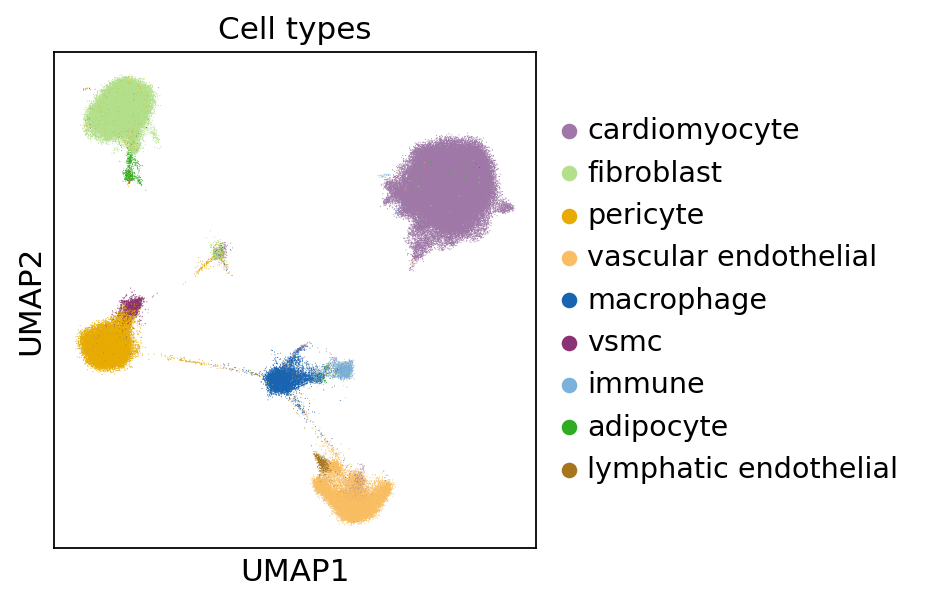

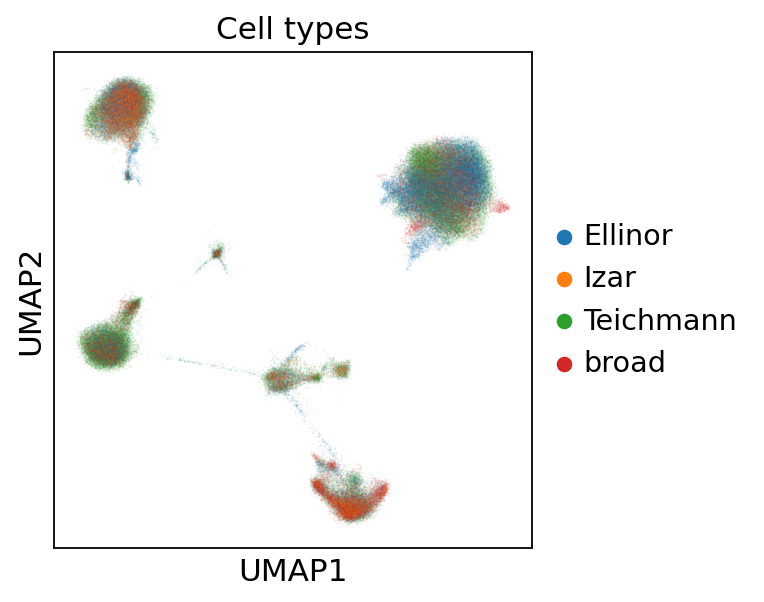

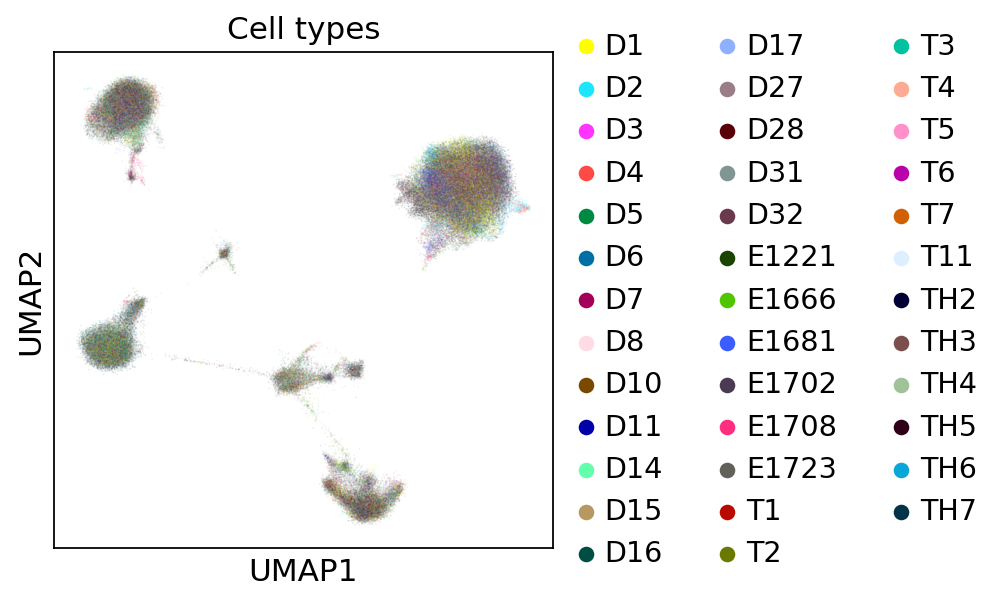

In [24]:
plt.figure(figsize=(6, 4))

sc.pl.embedding(adata, basis='umap', color='cluster', ax=plt.gca(), show=False)
plt.title('Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/heart_meta_cluster_umap.pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(5, 4))

sc.pl.embedding(adata, basis='umap', color='study', ax=plt.gca(), show=False, size=2, alpha=0.1)
plt.title('Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/heart_meta_study_umap.pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(6.5, 4))

sc.pl.embedding(adata, basis='umap', color='individual', ax=plt.gca(), show=False, size=2, alpha=0.1)
plt.title('Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/heart_meta_individual_umap.pdf', bbox_inches='tight')

plt.show()

## Extended Data Figures 11j, 11k

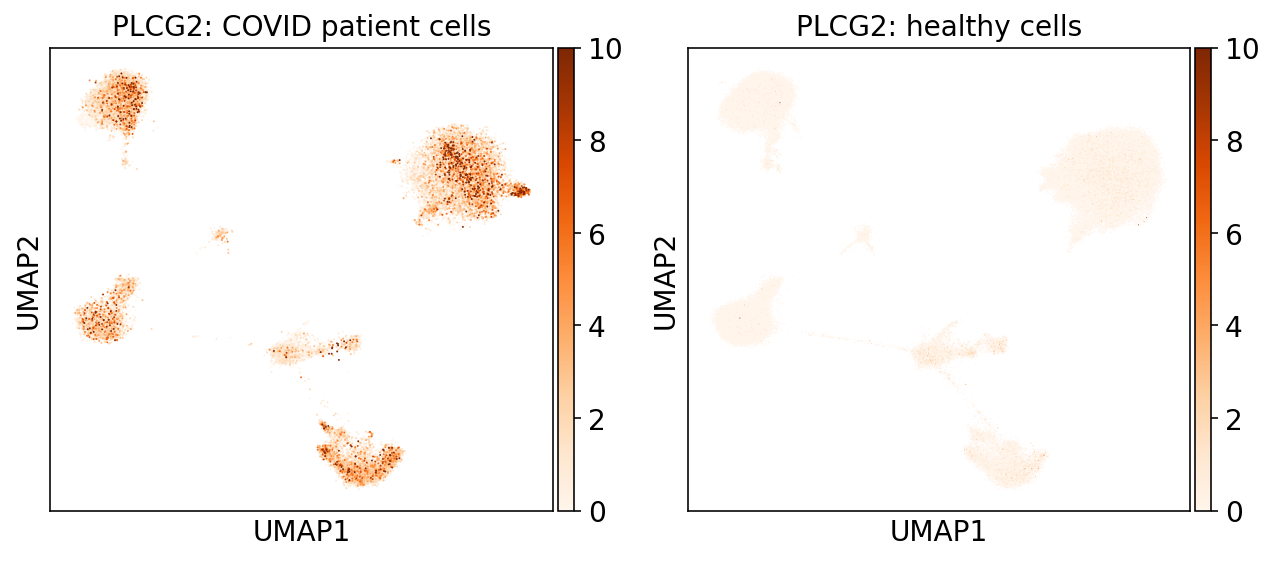

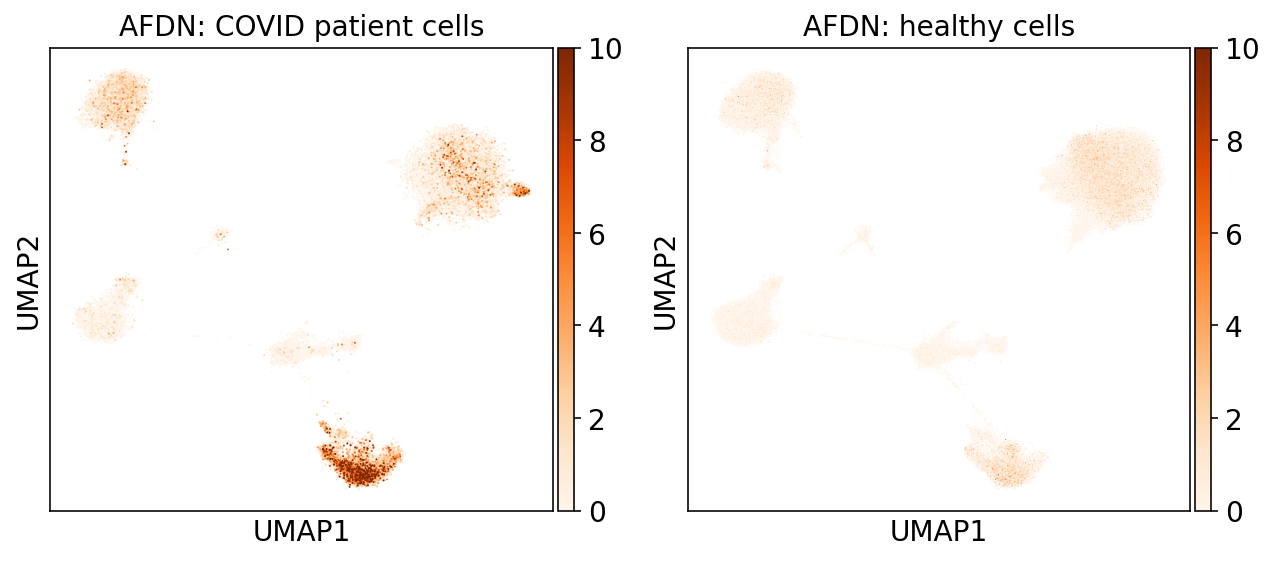

In [160]:
for g in ['PLCG2', 'AFDN']:

    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    sc.pl.embedding(adata[adata.obs['disease'] == 'COVID19'], color_map='Oranges',
                    basis='umap', color=g, ax=plt.gca(), show=False, vmax=10)
    plt.title(f'{g}: COVID patient cells')
    plt.subplot(1, 2, 2)
    sc.pl.embedding(adata[adata.obs['disease'] == 'healthy'], color_map='Oranges',
                    basis='umap', color=g, ax=plt.gca(), show=False, vmax=10)
    plt.title(f'{g}: healthy cells')
    
    plt.tight_layout()
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/heart_meta_{g}_umaps.pdf', bbox_inches='tight')
    
    plt.show()